# Create all image csv files

In [1]:
# import os
# import csv

# def create_csv(image_folder, csv_file_path):
#     # Define the CSV header fields
#     fieldnames = ['HospitalID', 'PatientID', 'ImageID', 'ImagePath', 'Label']
    
#     # Open the CSV file in write mode
#     with open(csv_file_path, 'w', newline='') as csvfile:
#         # Create a CSV writer object and write the header
#         writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
#         writer.writeheader()

#         # Iterate through files in the folder
#         for filename in sorted(os.listdir(image_folder)):
#             # Construct the complete image file path
#             image_path = os.path.join(image_folder, filename)

#             # Parse the filename to extract HospitalID, PatientID, image number, and image label
#             parts = filename.split('_')
#             hospital_id = parts[3]
#             patient_id = parts[1]
#             image_number = parts[6]
#             image_label = parts[4]

#             # Write data into the CSV file
#             writer.writerow({
#                 'HospitalID': hospital_id,
#                 'PatientID': patient_id,
#                 'ImageID': image_number,
#                 'ImagePath': image_path,
#                 'Label': image_label
#             })

#     # Print a message indicating that the CSV file has been created and saved
#     print("CSV file has been created and saved to:", csv_file_path)


# image_folder = "/local/data1/honzh073/data/8bit_down224"
# csv_file_path = "/local/data1/honzh073/local_repository/FL/code/3_single_hospital/csv_files/image_data.csv"
# create_csv(image_folder, csv_file_path)


CSV file has been created and saved to: /local/data1/honzh073/local_repository/FL/code/3_single_hospital/csv_files/image_data.csv


# create train, val csv

In [5]:
# import csv
# from collections import defaultdict
# import random

# def split_and_save_data(input_csv_path, output_folder, target_hospital_ids, train_ratio, seed):
#     patient_data = defaultdict(list)
    
#     with open(input_csv_path, 'r') as csvfile:
#         reader = csv.DictReader(csvfile)
#         for row in reader:
#             if row['HospitalID'] in target_hospital_ids:
#                 patient_id = row['PatientID']
#                 patient_data[patient_id].append(row)

#     num_patients = len(patient_data)

#     num_train = int(num_patients * train_ratio)

#     # get random IDs
#     all_patient_ids = list(patient_data.keys())

#     random.seed(seed)
#     random.shuffle(all_patient_ids)

#     # split by ID
#     train_patients = all_patient_ids[ : num_train]
#     test_patients = all_patient_ids[num_train: ]

#     # iter by patient IDs
#     train_data = []
#     test_data = []

#     for patient_id, images in patient_data.items():
#         if patient_id in train_patients:
#             train_data.extend(images)
#         elif patient_id in test_patients:
#             test_data.extend(images)

#     # write to csv
#     def write_to_csv(file_path, data):
#         with open(file_path, 'w', newline='') as csvfile:
#             writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
#             writer.writeheader()
#             writer.writerows(data)

#     # Write to CSV files
#     write_to_csv(os.path.join(output_folder, 'cross_train.csv'), train_data)
#     write_to_csv(os.path.join(output_folder, 'cross_test.csv'), test_data)
    
#     print("Saved train.csv, test.csv.")

# # input and output path
# input_csv_path = "/local/data1/honzh073/local_repository/FL/code/3_single_hospital/csv_files/image_data.csv"
# output_folder = '/local/data1/honzh073/local_repository/FL/code/3_single_hospital/csv_files/'

# # single hospital id
# target_hospital_ids = ['43']

# # random seed
# seed = 1

# # train and val dataset ratio
# train_ratio = 0.7
# # test_ratio = 0.3 # unnecessary

# split_and_save_data(input_csv_path, output_folder,
#                     train_ratio=train_ratio,
#                     target_hospital_ids = target_hospital_ids,
#                     seed = seed)


IndexError: list index out of range

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
   
def plot_roc_curve(all_labels, all_predictions):
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def show_image(dataset, num_images=5):
    # Get random indices
    random_indices = np.random.choice(len(dataset), num_images, replace=False)

    # Plot images with truncated names
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):
        image, label = dataset[idx]  # Use the dataset directly
        filename = dataset.data[idx][0]  # Get the filename from dataset's internal data attribute
        truncated_filename = filename.split('/')[-1][:15]  # Extract the last part and truncate to 15 characters
        
        # Print the original filename
        print(f"Image location: {filename}")

        plt.subplot(1, num_images, i + 1)
        plt.title(f"Label: {label}")
        plt.imshow(image[0])  # Assuming single-channel (grayscale) image
        # plt.imshow(image[0], cmap='gray')  # Assuming single-channel (grayscale) image

        plt.axis('off')
    plt.show()
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_classweight(train_dataset):
    train_nff_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
    train_aff_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
    class_weight_nff = 1 / (2 * (train_nff_count / (train_nff_count + train_aff_count)))
    class_weight_aff = 1 / (2 * (train_aff_count / (train_nff_count + train_aff_count)))
    
    return [class_weight_nff, class_weight_aff] # 0 nff , 1 aff


def test_model(model, test_dataset, batch_size):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    model.eval()
    
    correct_test = 0
    total_test = 0
    test_loss = 0
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            test_loss += loss.item()

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
     
    auc_score = roc_auc_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Precision、Recall、F1 Score
    class_labels = {0: 'NFF', 1: 'AFF'}

    classification_rep = classification_report(all_labels, all_predictions, target_names=[class_labels[i] for i in range(len(class_labels))])
    print("AUC:", auc_score)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_rep)

    plot_roc_curve(all_labels, all_predictions)

training class weight [0.7205882352941176, 1.6333333333333333]
Image location: /local/data1/honzh073/data/8bit_down224/patient_YWPBQDLSEV_hospital_43_AFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_YKVUJXHELG_hospital_43_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_HVTVEBPSCC_hospital_43_NFF_image_5.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_SNNNBFDZBB_hospital_43_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_HGGEYYVSEJ_hospital_43_NFF_image_2.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_HIOOQPEKJC_hospital_43_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_XXHINYNRCP_hospital_43_AFF_image_1.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_XWSXMJCZWA_hospital_43_NFF_image_3.png
Image location: /local/data1/honzh073/data/8bit_down224/patient_YKGTKOEZOD_hospital_43_AFF_image_3.png
Image loca

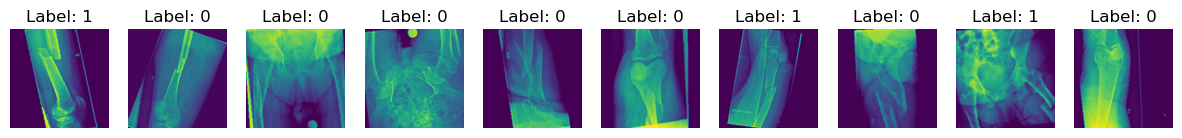

Saved train.csv, val.csv, test.csv.
-----------------------------------
train AFF: 75, ratio: 0.31
----- NFF: 170, ratio: 0.69
-----------------------------------
test AFF: 28, ratio: 0.16
---- NFF: 152, ratio: 0.84


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import csv
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from sklearn.model_selection import KFold

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = []
        self.labels = []  # Store labels separately
        self.patient_ids = []  # Store patient IDs separately
        self.transform = transform
        
        # read csv
        with open(csv_file, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_path = row['ImagePath']
                label = row['Label']
                patient_id = row['PatientID']  # Assuming 'PatientID' is the column name in your CSV file

                if label == 'NFF':
                    label = 0
                elif label == 'AFF':
                    label = 1
                else:
                    raise ValueError("Invalid label in CSV file.")
                self.data.append((image_path, label))
                self.labels.append(label)
                self.patient_ids.append(patient_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your image transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAdjustSharpness(sharpness_factor=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets using CustomDataset class
train_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/3_single_hospital/csv_files/cross_train.csv', transform=train_transform)
test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/3_single_hospital/csv_files/hospital55.csv', transform=test_transform)

# classweight
classweight = get_classweight(train_dataset)
print('training class weight', classweight)

# device
# device = torch.device("cuda:0" if  torch.cuda.is_available() else "cpu")

# print images
show_image(train_dataset, 10)

# calculate numbers
print("Saved train.csv, val.csv, test.csv.")
print('-----------------------------------')
train_NFF_count = sum(1 for _, label in train_dataset if label == 0)  # 0 NFF
train_AFF_count = sum(1 for _, label in train_dataset if label == 1)  # 1 AFF
test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF

print(f"train AFF: {train_AFF_count}, ratio: {train_AFF_count / (train_AFF_count + train_NFF_count):.2f}")
print(f"----- NFF: {train_NFF_count}, ratio: {train_NFF_count / (train_AFF_count + train_NFF_count):.2f}")
print('-----------------------------------')
print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")



/local/data1/honzh073/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Fold 1/5
Epoch 1/30, train Loss: 0.1568, val Loss: 0.5742, train ACC: 62.76%, Val ACC: 53.06%
Epoch 2/30, train Loss: 0.5870, val Loss: 0.5581, train ACC: 67.86%, Val ACC: 67.35%
Epoch 3/30, train Loss: 0.8616, val Loss: 0.7901, train ACC: 79.59%, Val ACC: 63.27%
Epoch 4/30, train Loss: 0.4943, val Loss: 0.4710, train ACC: 81.12%, Val ACC: 79.59%
Epoch 5/30, train Loss: 0.1944, val Loss: 0.6494, train ACC: 85.20%, Val ACC: 69.39%
Epoch 6/30, train Loss: 0.3846, val Loss: 0.8659, train ACC: 85.20%, Val ACC: 73.47%
Epoch 7/30, train Loss: 0.0709, val Loss: 0.3676, train ACC: 93.88%, Val ACC: 89.80%
Epoch 8/30, train Loss: 0.2590, val Loss: 0.4987, train ACC: 88.78%, Val ACC: 79.59%
Epoch 9/30, train Loss: 0.3198, val Loss: 0.4402, train ACC: 91.33%, Val ACC: 89.80%
Epoch 10/30, train Loss: 0.2583, val Loss: 0.2712, train ACC: 93.37%, Val ACC: 93.88%
Epoch 11/30, train Loss: 0.0140, val Loss: 0.3263, train ACC: 90.31%, Val ACC: 77.55%
Epoch 12/30, train Loss: 1.8121, val Loss: 0.7387, tra

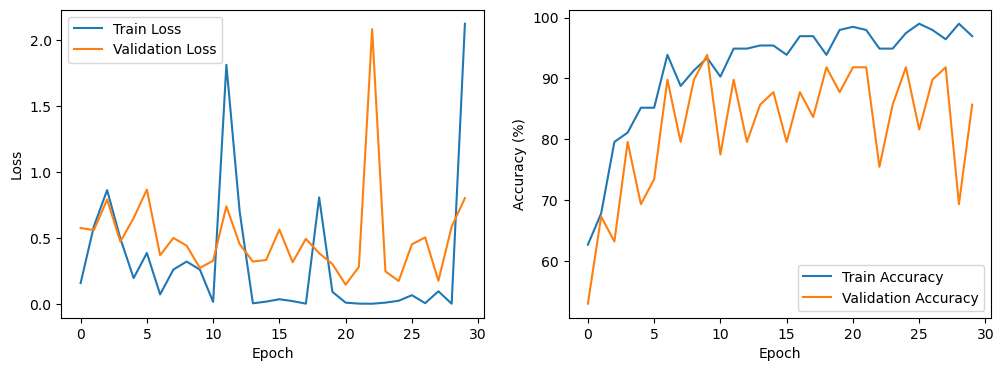

Fold 2/5
Epoch 1/30, train Loss: 0.0004, val Loss: 0.0779, train ACC: 95.41%, Val ACC: 93.88%
Epoch 2/30, train Loss: 0.0000, val Loss: 0.0301, train ACC: 97.45%, Val ACC: 100.00%
Epoch 3/30, train Loss: 0.0015, val Loss: 0.0232, train ACC: 94.90%, Val ACC: 100.00%
Epoch 4/30, train Loss: 0.0137, val Loss: 0.0084, train ACC: 98.47%, Val ACC: 100.00%
Epoch 5/30, train Loss: 0.0771, val Loss: 0.0647, train ACC: 95.41%, Val ACC: 97.96%
Epoch 6/30, train Loss: 0.0096, val Loss: 0.0249, train ACC: 97.96%, Val ACC: 100.00%
Epoch 7/30, train Loss: 0.0018, val Loss: 0.0084, train ACC: 97.96%, Val ACC: 100.00%
Epoch 8/30, train Loss: 0.0000, val Loss: 0.0234, train ACC: 98.47%, Val ACC: 100.00%
Epoch 9/30, train Loss: 0.0548, val Loss: 0.0566, train ACC: 95.41%, Val ACC: 97.96%
Epoch 10/30, train Loss: 0.0074, val Loss: 0.0461, train ACC: 97.45%, Val ACC: 97.96%
Epoch 11/30, train Loss: 0.0004, val Loss: 0.0306, train ACC: 98.47%, Val ACC: 97.96%
Epoch 12/30, train Loss: 0.0032, val Loss: 0.009

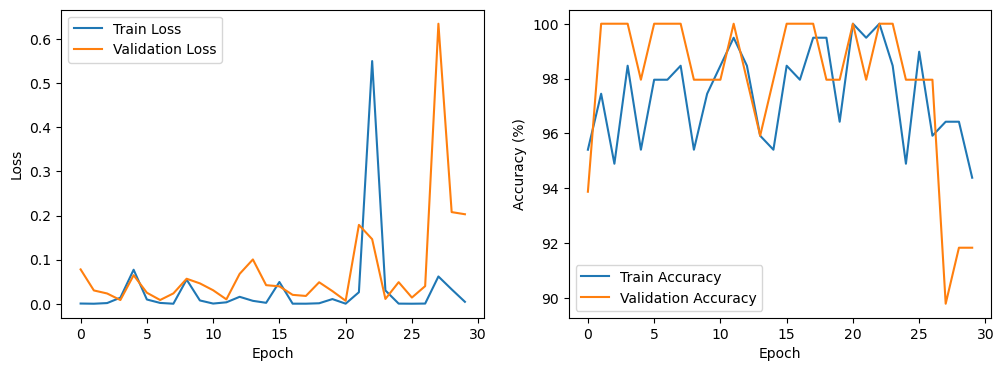

Fold 3/5
Epoch 1/30, train Loss: 0.0000, val Loss: 0.0159, train ACC: 95.41%, Val ACC: 100.00%
Epoch 2/30, train Loss: 0.0015, val Loss: 0.0793, train ACC: 98.98%, Val ACC: 97.96%
Epoch 3/30, train Loss: 0.0205, val Loss: 0.0862, train ACC: 96.94%, Val ACC: 93.88%
Epoch 4/30, train Loss: 0.0078, val Loss: 0.0189, train ACC: 95.92%, Val ACC: 100.00%
Epoch 5/30, train Loss: 0.0000, val Loss: 0.0124, train ACC: 98.47%, Val ACC: 100.00%
Epoch 6/30, train Loss: 0.0301, val Loss: 0.0225, train ACC: 99.49%, Val ACC: 100.00%
Epoch 7/30, train Loss: 0.0000, val Loss: 0.0043, train ACC: 98.98%, Val ACC: 100.00%
Epoch 8/30, train Loss: 0.0004, val Loss: 0.0259, train ACC: 99.49%, Val ACC: 97.96%
Epoch 9/30, train Loss: 0.0000, val Loss: 0.0297, train ACC: 99.49%, Val ACC: 97.96%
Epoch 10/30, train Loss: 0.0051, val Loss: 0.0402, train ACC: 100.00%, Val ACC: 97.96%
Epoch 11/30, train Loss: 0.0024, val Loss: 0.0025, train ACC: 99.49%, Val ACC: 100.00%
Epoch 12/30, train Loss: 0.0000, val Loss: 0.00

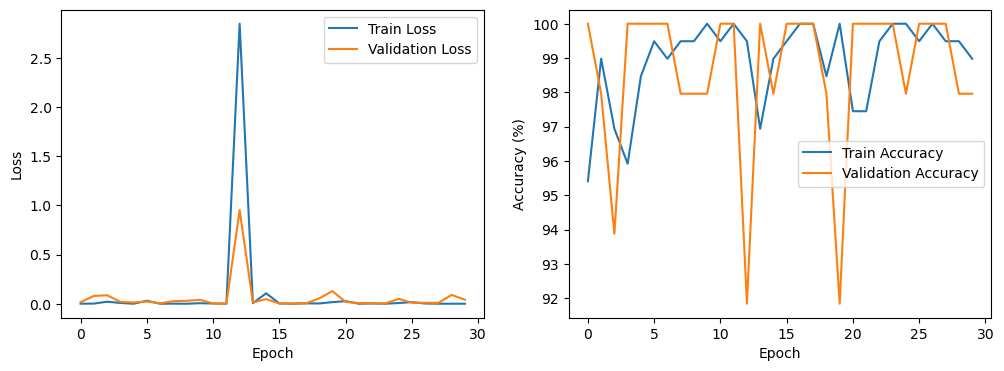

Fold 4/5
Epoch 1/30, train Loss: 0.0000, val Loss: 0.0625, train ACC: 96.94%, Val ACC: 97.96%
Epoch 2/30, train Loss: 0.0036, val Loss: 0.0067, train ACC: 98.98%, Val ACC: 100.00%
Epoch 3/30, train Loss: 0.0452, val Loss: 0.0387, train ACC: 97.45%, Val ACC: 97.96%
Epoch 4/30, train Loss: 0.0000, val Loss: 0.0190, train ACC: 97.96%, Val ACC: 97.96%
Epoch 5/30, train Loss: 0.0000, val Loss: 0.0352, train ACC: 97.96%, Val ACC: 97.96%
Epoch 6/30, train Loss: 0.0083, val Loss: 0.0171, train ACC: 98.98%, Val ACC: 100.00%
Epoch 7/30, train Loss: 0.0000, val Loss: 0.0118, train ACC: 98.47%, Val ACC: 100.00%
Epoch 8/30, train Loss: 0.0264, val Loss: 0.0085, train ACC: 100.00%, Val ACC: 100.00%
Epoch 9/30, train Loss: 0.0000, val Loss: 0.0038, train ACC: 100.00%, Val ACC: 100.00%
Epoch 10/30, train Loss: 0.0000, val Loss: 0.0077, train ACC: 97.96%, Val ACC: 100.00%
Epoch 11/30, train Loss: 0.0000, val Loss: 0.0095, train ACC: 100.00%, Val ACC: 97.96%
Epoch 12/30, train Loss: 0.0000, val Loss: 0.

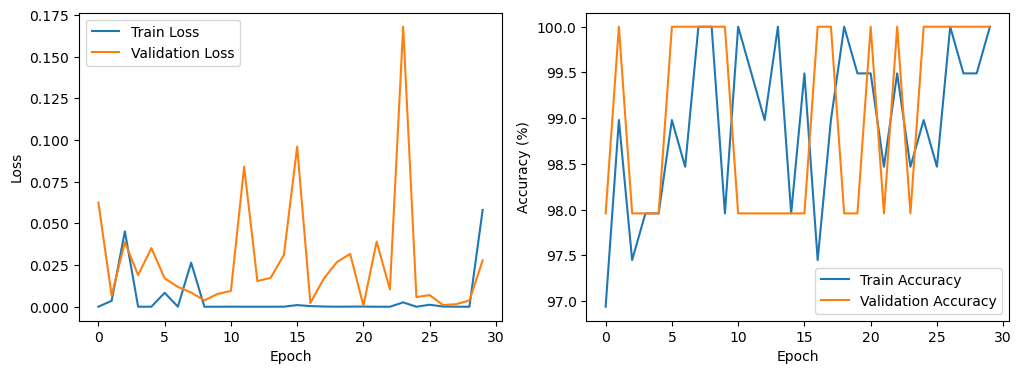

Fold 5/5
Epoch 1/30, train Loss: 0.0000, val Loss: 0.0043, train ACC: 98.98%, Val ACC: 100.00%
Epoch 2/30, train Loss: 0.0000, val Loss: 0.0022, train ACC: 98.47%, Val ACC: 100.00%
Epoch 3/30, train Loss: 0.0000, val Loss: 0.5033, train ACC: 99.49%, Val ACC: 87.76%
Epoch 4/30, train Loss: 0.0000, val Loss: 0.0305, train ACC: 94.39%, Val ACC: 97.96%
Epoch 5/30, train Loss: 0.0006, val Loss: 0.0720, train ACC: 98.98%, Val ACC: 97.96%
Epoch 6/30, train Loss: 0.0000, val Loss: 0.0050, train ACC: 100.00%, Val ACC: 100.00%
Epoch 7/30, train Loss: 0.0005, val Loss: 0.0066, train ACC: 98.98%, Val ACC: 100.00%
Epoch 8/30, train Loss: 0.0001, val Loss: 0.0047, train ACC: 100.00%, Val ACC: 100.00%
Epoch 9/30, train Loss: 0.0000, val Loss: 0.0130, train ACC: 98.98%, Val ACC: 100.00%
Epoch 10/30, train Loss: 0.0024, val Loss: 0.0075, train ACC: 99.49%, Val ACC: 100.00%
Epoch 11/30, train Loss: 0.0000, val Loss: 0.0115, train ACC: 99.49%, Val ACC: 100.00%
Epoch 12/30, train Loss: 0.0002, val Loss: 0

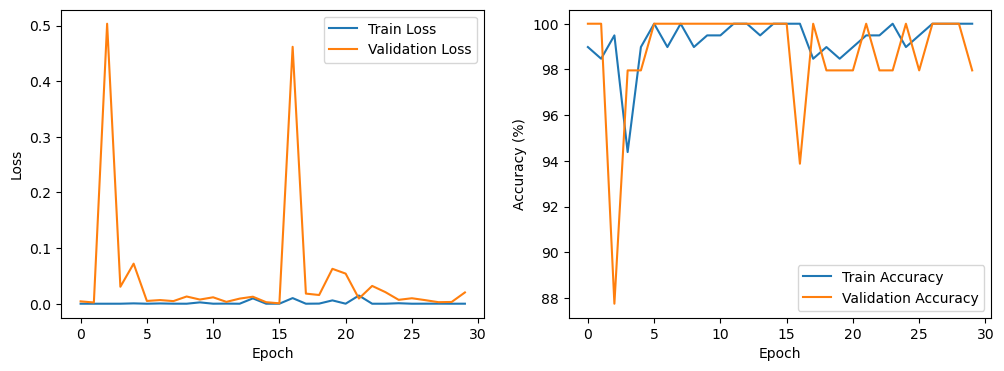

In [10]:
# from sklearn.model_selection import StratifiedKFold
# from torchvision.models import resnet101, ResNet101_Weights

# classweight = get_classweight(train_dataset)

# torch.hub.set_dir('/local/data1/honzh073/download/TORCH_PRETRAINED')
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Define the ResNet-101 model
# model = models.resnet101(weights=ResNet101_Weights.DEFAULT)

# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 2)  # Assuming 2 classes, change it according to your problem
# model = model.to(device)

# # Define your loss function and optimizer
# criterion = nn.CrossEntropyLoss(weight=torch.Tensor(classweight).to(device))

# optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
# # scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# # Define the number of splits for cross-validation
# n_splits = 5
# # kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
# kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

# # k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)), train_dataset.patient_ids)):

# # for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(train_dataset)))):
#     print(f'Fold {fold + 1}/{n_splits}')

#     # Create data loaders for training and validation subsets
#     train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
#     val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

#     train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)
#     val_loader = DataLoader(train_dataset, batch_size=16, sampler=val_sampler)

#     # Training loop
#     num_epochs = 30  # Choose the number of epochs
    
#     # Loss, ACC
#     train_losses = []
#     validation_losses = []
#     train_accuracies = []
#     validation_accuracies = []
    
#     for epoch in range(num_epochs):
#         model.train()
#         correct_train = 0
#         total_train = 0
        
#         for images, labels in train_loader:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             _, predicted = torch.max(outputs.data, 1)
#             total_train += labels.size(0)
#             correct_train += (predicted == labels).sum().item()
        
#         train_accuracy = 100 * correct_train / total_train
        
#         model.eval()
#         correct_validation_aff = 0
#         total_validation_aff = 0
#         correct_validation = 0
#         total_validation = 0
#         validation_loss = 0
        
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images = images.to(device)
#                 labels = labels.to(device)
                
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
                
#                 _, predicted = torch.max(outputs.data, 1)
#                 total_validation += labels.size(0)
#                 correct_validation += (predicted == labels).sum().item()
#                 validation_loss += loss.item()
#                 # Calculate accuracy for AFF class
#                 total_validation_aff += torch.sum(labels == 1).item()
#                 correct_validation_aff += torch.sum((predicted == 1) & (labels == 1)).item()

#         # validation_accuracy_aff = 100 * correct_validation_aff / total_validation_aff

#         # validation accuracy and loss
#         validation_accuracy = 100 * correct_validation / total_validation
#         validation_loss /= len(val_loader)
        
#         train_losses.append(loss.item())
#         validation_losses.append(validation_loss)
#         train_accuracies.append(train_accuracy)
#         validation_accuracies.append(validation_accuracy)
        
#         print(f"Epoch {epoch+1}/{num_epochs}, "
#             f"train Loss: {loss.item():.4f}, "
#             f"val Loss: {validation_loss:.4f}, "
#             f"train ACC: {train_accuracy:.2f}%, "
#             f"Val ACC: {validation_accuracy:.2f}%")
#         # scheduler.step()
        
#     # Plot train/val loss,  accuracy
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(train_losses, label='Train Loss')
#     plt.plot(validation_losses, label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(train_accuracies, label='Train Accuracy')
#     plt.plot(validation_accuracies, label='Validation Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy (%)')
#     plt.legend() 

#     plt.show()



ResNet 101
test AFF: 28, ratio: 0.16
---- NFF: 152, ratio: 0.84
Test Loss: 0.3776, Test Acc: 93.33%
AUC: 0.8439849624060152
Confusion Matrix:
[[148   4]
 [  8  20]]
Classification Report:
              precision    recall  f1-score   support

         NFF       0.95      0.97      0.96       152
         AFF       0.83      0.71      0.77        28

    accuracy                           0.93       180
   macro avg       0.89      0.84      0.87       180
weighted avg       0.93      0.93      0.93       180



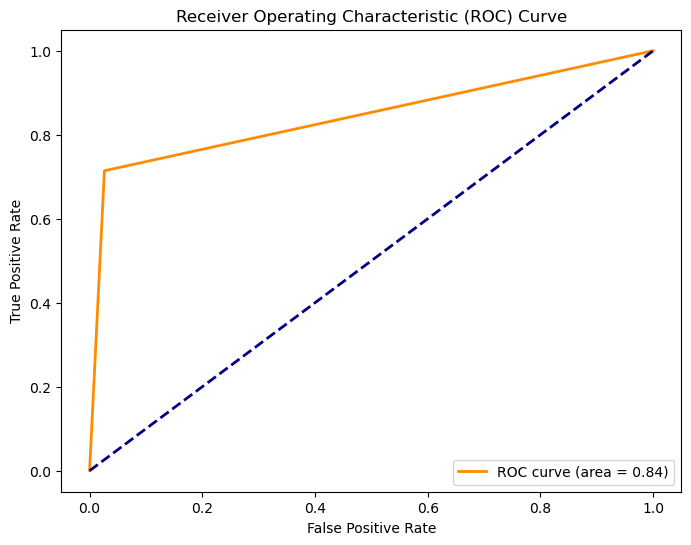

number of parameters: 42504258


In [13]:
# # Resnet 101 on hospital 55
# print('ResNet 101')
# test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/3_single_hospital/csv_files/hospital55.csv', transform=test_transform)
# # For test dataset
# test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
# test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF
# print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
# print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")

# test_model(model, test_dataset=test_dataset, batch_size=16)
# params_count = count_parameters(model)
# print(f"number of parameters: {params_count}")


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 定义ResNet-101模型
class ResNet101(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet101, self).__init__()
        self.inplanes = 64  
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 23, stride=2)
        self.layer4 = self._make_layer(512, 3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, planes, blocks, stride=1):
        layers = []
        layers.append(Bottleneck(self.inplanes, planes, stride))
        self.inplanes = planes * 4  
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  
        x = self.fc(x)
        return x

# 定义Bottleneck模块
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if stride != 1 or inplanes != planes * Bottleneck.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * Bottleneck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * Bottleneck.expansion),
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# 加载预训练的ResNet-101模型参数
model = ResNet101(num_classes=2)
pretrained_dict = torch.load('/local/data1/honzh073/data/suzuki.ad.liu.se/transfer/71336ca0-1ffa-43df-a64b-22f843559fd2/workspace/app_server/FL_global_model.pt')
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)


# 定义测试数据集和数据加载器
test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/3_single_hospital/csv_files/hospital55.csv', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 确定使用的设备（CPU或GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# 测试模型
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将数据移到设备上
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# 在测试数据集上评估模型
print('FL')
test_model(model, test_loader)
params_count = count_parameters(model)
print(f"Number of Parameters: {params_count}")



FL
Test Accuracy: 84.44%
Number of Parameters: 42504258


In [13]:
# real world global model
import torch

checkpoint = torch.load('/local/data1/honzh073/data/suzuki.ad.liu.se/transfer/c31688e7-eac0-4160-9fd6-bdbda29cbbb2/workspace/app_server/FL_global_model.pt')
print(checkpoint.keys())


odict_keys(['model', 'train_conf'])


In [15]:
# # FL
# # Resnet 101 on hospital 55
# from torchvision.models import resnet101, ResNet101_Weights

# print('FL')
# test_dataset = CustomDataset('/local/data1/honzh073/local_repository/FL/code/3_single_hospital/csv_files/hospital55.csv', transform=test_transform)
# # For test dataset
# test_NFF_count = sum(1 for _, label in test_dataset if label == 0)  # 0 NFF
# test_AFF_count = sum(1 for _, label in test_dataset if label == 1)  # 1 AFF
# print(f"test AFF: {test_AFF_count}, ratio: {test_AFF_count / (test_AFF_count + test_NFF_count):.2f}")
# print(f"---- NFF: {test_NFF_count}, ratio: {test_NFF_count / (test_AFF_count + test_NFF_count):.2f}")


# test_model(model, test_dataset=test_dataset, batch_size=16)
# params_count = count_parameters(model)
# print(f"number of parameters: {params_count}")
